IMPORT THE LIBRARIES

In [ ]:
import re
import os
import pandas as pd
import numpy as np
import torch
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.image import imread
from io import StringIO
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader ,random_split
from torchvision import datasets ,models , transforms
from pathlib import Path
import torchvision
from PIL import Image
import torchvision.models as models
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

In [ ]:
#Mount the drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#!unzip -uq "/content/gdrive/My Drive/COMP5329_Assignment/COMP5329S1A2Dataset.zip" -d "/content/gdrive/My Drive/COMP5329_Assignment/Dataset"

In [ ]:
# Change the path for the dataset
path = '/content/gdrive/MyDrive/COMP5329_Assignment/Dataset/COMP5329S1A2Dataset'
folder = path + '/data/'

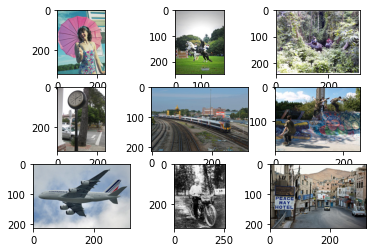

In [ ]:
# plot the first 9 images in the dataset to show
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    name = folder + str(i) + '.jpg'
    # load image pixels
    im_1 = imread(name)
    # plot raw pixel data
    plt.imshow(im_1)
# show the figure
plt.show()

In [ ]:
FILE = path + '/train.csv'

with open(FILE) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]

train_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
print(len(train_data))
train_data.head()

29996


,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


Convert to One-Hot Encoding

In [ ]:
train_data['Labels2']= train_data['Labels'].replace(' ',',', regex=True).astype(str)
Labels3 = train_data['Labels'].apply(lambda x: pd.Series(x.split(' ')))
labels4=Labels3.fillna('').values

one_hot = MultiLabelBinarizer()

Labels5=pd.DataFrame(one_hot.fit_transform(labels4))
Labels5.columns=one_hot.class_
Labels5.drop('', axis=1, inplace=True) 
Labels5['ColumnA'] = Labels5[Labels5.columns[:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
train_data['Labels']=Labels5['ColumnA']
train_data = train_data.drop(['Labels2'], axis = 1)
train_data.head()

,ImageID,Labels,Caption
0,0.jpg,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",Woman in swim suit holding parasol on sunny day.
1,1.jpg,"1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0",A couple of men riding horses on top of a gree...
2,2.jpg,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",They are brave for riding in the jungle on tho...
3,3.jpg,"0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0",a black and silver clock tower at an intersect...
4,4.jpg,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0",A train coming to a stop on the tracks out side.


In [ ]:
print("Number of samples: ",len(train_data))
print("Number of Labels: ",len(np.unique(train_data.Labels)))

Number of samples:  29996
Number of Labels:  713


NORMALISE DATA

In [ ]:
class MyData(Dataset):
  def __init__(self , csv_file , image_dir , transforms=None):
    
    # self.def = pd.read_csv(csv_file)
    self.def = csv_file
    self.image_dir = image_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.def.iloc[idx]
    img_path = os.path.join(folder, d.ImageID)
    image = Image.open(img_path).convert("RGB")
    
    label = d.Labels.split(',')
    labels = np.array(label).astype(np.float32)
    # labels = np.array(label).astype(np.float32)
    # labels = torch.from_numpy(labels)
    
    if self.transforms is not None:
      image = self.transforms(image)
    
    return image,labels.astype(float)
  
  def __len__(self):
    return len(self.def)

In [ ]:
batch_size=20
transform = transforms.Compose([transforms.Resize((224,224)) , 
                                # transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset1 = MyData(train_data, Path(folder) , transform)
valid_no = int(len(dataset1)*0.2) 
trainset ,valset  = random_split( dataset1 , [len(dataset1) -valid_no  ,valid_no])
print(f"length of training set: {len(trainset)} length of validation set: {len(valset)}")


dataloader = {"train_data":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

length of training set: 23997 length of validation set: 5999


In [ ]:
plt.imshow(torchvision.utils.make_grid(dataset[0][0]).permute(1, 2, 0))

OSError: ignored

## Model

In [ ]:
#Loading a pretrained model
googlenet = models.googlenet(pretrained=True)

In [ ]:
# get the no of on_features in last Linear unit
num_features = googlenet.fc.in_features 
print(num_features)
## freeze the entire convolution base
for param in googlenet.parameters():
  param.requires_grad_(False)

In [ ]:
#Changing the number of input features in the last layer
googlenet.fc = nn.Linear(num_features, 18)
googlenet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.fc = nn.Linear(num_features, 18)
googlenet = googlenet.to(device)
criteria = nn.BCEWithLogitsLoss()


# specify optimizer
optimise = optim.SGD(googlenet.parameters(), lr=0.1)
sgdr_part = lr_scheduler.CosineAnnealingLR(optimise, T_max=5, eta_min=0.005 )

In [ ]:
#Train Function
def train_data(googlenet , data_loader , criteria , optimise ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase1 in ['train_data', 'val']:
      if phase1=="train_data":     # put the model in training mode
        googlenet.train_data()
        # scheduler.step()
      else:     # put the model in validation mode
        googlenet.eval()
       
      # keep track of training and validation loss
      run_loss = 0.0
      run_corrects = 0.0  
      
      for data , target in data_loader[phase1]:
        #load the data and target to GPU
        data , target = data.to(device)  , target.to(device)
 
        with torch.set_grad_enabled(phase1=="train_data"):
          if phase1=="train_data"  :
            # zero the grad to stop it from accumulating
            optimise.zero_grad()

          #feed the input
          output = googlenet(data)
          #calculate the loss
          loss = criteria(output,target)
          predict = torch.sigmoid(output).data > 0.5
          # add weights?
          predict = predict.to(torch.float32)
          
          if phase1=="train_data"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimise.step()          
            scheduler.step()


        # statistics
        run_loss += loss.item() * data.size(0)
        run_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,predict.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch1_loss = run_loss / len(data_loader[phase1].dataset)
      epoch1_acc = run_corrects / len(data_loader[phase1].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase1, epoch1_loss, epoch1_acc))
    print(result)

In [ ]:
train_data(googlenet, dataloader , criteria, optimise,sgdr_part,num_epochs=30)



Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   2%|▏         | 1/50 [2:20:27<114:42:10, 8427.16s/it]

['train Loss: 0.1817 Acc: 0.6349', 'val Loss: 0.1545 Acc: 0.6577']




Epochs:   4%|▍         | 2/50 [2:23:04<79:16:56, 5946.18s/it] 

['train Loss: 0.1507 Acc: 0.6506', 'val Loss: 0.1384 Acc: 0.6915']




Epochs:   6%|▌         | 3/50 [2:25:40<54:57:14, 4209.25s/it]

['train Loss: 0.1399 Acc: 0.6753', 'val Loss: 0.1300 Acc: 0.7201']




Epochs:   8%|▊         | 4/50 [2:28:17<38:15:02, 2993.53s/it]

['train Loss: 0.1335 Acc: 0.6917', 'val Loss: 0.1258 Acc: 0.7278']




Epochs:  10%|█         | 5/50 [2:30:54<26:46:52, 2142.49s/it]

['train Loss: 0.1303 Acc: 0.7007', 'val Loss: 0.1232 Acc: 0.7229']




Epochs:  12%|█▏        | 6/50 [2:33:30<18:54:07, 1546.53s/it]

['train Loss: 0.1274 Acc: 0.7088', 'val Loss: 0.1204 Acc: 0.7362']




Epochs:  14%|█▍        | 7/50 [2:36:05<13:29:11, 1129.11s/it]

['train Loss: 0.1258 Acc: 0.7151', 'val Loss: 0.1201 Acc: 0.7312']




Epochs:  16%|█▌        | 8/50 [2:38:40<9:45:54, 837.01s/it]  

['train Loss: 0.1246 Acc: 0.7209', 'val Loss: 0.1177 Acc: 0.7525']




Epochs:  18%|█▊        | 9/50 [2:41:16<7:12:11, 632.48s/it]

['train Loss: 0.1233 Acc: 0.7211', 'val Loss: 0.1175 Acc: 0.7460']




Epochs:  20%|██        | 10/50 [2:43:51<5:26:17, 489.43s/it]

['train Loss: 0.1226 Acc: 0.7238', 'val Loss: 0.1176 Acc: 0.7554']




Epochs:  22%|██▏       | 11/50 [2:46:27<4:13:01, 389.26s/it]

['train Loss: 0.1214 Acc: 0.7290', 'val Loss: 0.1156 Acc: 0.7544']




Epochs:  24%|██▍       | 12/50 [2:49:04<3:22:22, 319.53s/it]

['train Loss: 0.1207 Acc: 0.7297', 'val Loss: 0.1154 Acc: 0.7579']




Epochs:  26%|██▌       | 13/50 [2:51:41<2:46:58, 270.78s/it]

['train Loss: 0.1202 Acc: 0.7335', 'val Loss: 0.1148 Acc: 0.7604']




Epochs:  28%|██▊       | 14/50 [2:54:18<2:22:00, 236.69s/it]

['train Loss: 0.1196 Acc: 0.7368', 'val Loss: 0.1148 Acc: 0.7614']




Epochs:  30%|███       | 15/50 [2:56:54<2:03:57, 212.49s/it]

['train Loss: 0.1190 Acc: 0.7383', 'val Loss: 0.1146 Acc: 0.7549']




Epochs:  32%|███▏      | 16/50 [2:59:31<1:51:00, 195.89s/it]

['train Loss: 0.1187 Acc: 0.7383', 'val Loss: 0.1138 Acc: 0.7603']




Epochs:  34%|███▍      | 17/50 [3:02:08<1:41:14, 184.07s/it]

['train Loss: 0.1184 Acc: 0.7402', 'val Loss: 0.1124 Acc: 0.7683']




Epochs:  36%|███▌      | 18/50 [3:04:45<1:33:57, 176.17s/it]

['train Loss: 0.1185 Acc: 0.7416', 'val Loss: 0.1133 Acc: 0.7563']




Epochs:  38%|███▊      | 19/50 [3:07:23<1:28:09, 170.62s/it]

['train Loss: 0.1176 Acc: 0.7422', 'val Loss: 0.1128 Acc: 0.7624']




Epochs:  40%|████      | 20/50 [3:10:00<1:23:17, 166.59s/it]

['train Loss: 0.1179 Acc: 0.7413', 'val Loss: 0.1134 Acc: 0.7595']




Epochs:  42%|████▏     | 21/50 [3:12:38<1:19:16, 164.02s/it]

['train Loss: 0.1175 Acc: 0.7447', 'val Loss: 0.1128 Acc: 0.7657']




Epochs:  44%|████▍     | 22/50 [3:15:16<1:15:41, 162.21s/it]

['train Loss: 0.1173 Acc: 0.7442', 'val Loss: 0.1122 Acc: 0.7587']




Epochs:  46%|████▌     | 23/50 [3:17:54<1:12:27, 161.01s/it]

['train Loss: 0.1169 Acc: 0.7448', 'val Loss: 0.1119 Acc: 0.7670']




Epochs:  48%|████▊     | 24/50 [3:20:33<1:09:25, 160.19s/it]

['train Loss: 0.1166 Acc: 0.7450', 'val Loss: 0.1129 Acc: 0.7511']




Epochs:  50%|█████     | 25/50 [3:23:11<1:06:27, 159.51s/it]

['train Loss: 0.1164 Acc: 0.7461', 'val Loss: 0.1115 Acc: 0.7679']




Epochs:  52%|█████▏    | 26/50 [3:25:49<1:03:38, 159.10s/it]

['train Loss: 0.1158 Acc: 0.7474', 'val Loss: 0.1119 Acc: 0.7639']




Epochs:  54%|█████▍    | 27/50 [3:28:26<1:00:46, 158.56s/it]

['train Loss: 0.1160 Acc: 0.7472', 'val Loss: 0.1120 Acc: 0.7623']




Epochs:  56%|█████▌    | 28/50 [3:31:03<58:01, 158.24s/it]  

['train Loss: 0.1162 Acc: 0.7482', 'val Loss: 0.1115 Acc: 0.7736']




Epochs:  58%|█████▊    | 29/50 [3:33:41<55:15, 157.90s/it]

['train Loss: 0.1157 Acc: 0.7492', 'val Loss: 0.1113 Acc: 0.7693']




Epochs:  60%|██████    | 30/50 [3:36:19<52:42, 158.11s/it]

['train Loss: 0.1158 Acc: 0.7485', 'val Loss: 0.1116 Acc: 0.7674']




Epochs:  62%|██████▏   | 31/50 [3:38:58<50:08, 158.35s/it]

['train Loss: 0.1159 Acc: 0.7477', 'val Loss: 0.1111 Acc: 0.7739']




Epochs:  64%|██████▍   | 32/50 [3:41:37<47:31, 158.41s/it]

['train Loss: 0.1156 Acc: 0.7490', 'val Loss: 0.1111 Acc: 0.7743']




Epochs:  66%|██████▌   | 33/50 [3:44:16<44:57, 158.65s/it]

['train Loss: 0.1156 Acc: 0.7486', 'val Loss: 0.1107 Acc: 0.7754']




Epochs:  68%|██████▊   | 34/50 [3:46:55<42:20, 158.77s/it]

['train Loss: 0.1155 Acc: 0.7504', 'val Loss: 0.1106 Acc: 0.7742']




Epochs:  70%|███████   | 35/50 [3:49:34<39:42, 158.85s/it]

['train Loss: 0.1151 Acc: 0.7494', 'val Loss: 0.1106 Acc: 0.7706']




Epochs:  72%|███████▏  | 36/50 [3:52:13<37:06, 159.02s/it]

['train Loss: 0.1150 Acc: 0.7524', 'val Loss: 0.1112 Acc: 0.7623']




Epochs:  74%|███████▍  | 37/50 [3:54:52<34:25, 158.88s/it]

['train Loss: 0.1147 Acc: 0.7514', 'val Loss: 0.1101 Acc: 0.7717']




Epochs:  76%|███████▌  | 38/50 [3:57:32<31:51, 159.25s/it]

['train Loss: 0.1147 Acc: 0.7528', 'val Loss: 0.1102 Acc: 0.7694']




Epochs:  78%|███████▊  | 39/50 [4:00:11<29:11, 159.22s/it]

['train Loss: 0.1148 Acc: 0.7518', 'val Loss: 0.1107 Acc: 0.7699']




Epochs:  80%|████████  | 40/50 [4:02:51<26:34, 159.41s/it]

['train Loss: 0.1150 Acc: 0.7497', 'val Loss: 0.1105 Acc: 0.7750']




Epochs:  82%|████████▏ | 41/50 [4:05:31<23:54, 159.44s/it]

['train Loss: 0.1146 Acc: 0.7505', 'val Loss: 0.1105 Acc: 0.7716']




Epochs:  84%|████████▍ | 42/50 [4:08:10<21:15, 159.50s/it]

['train Loss: 0.1145 Acc: 0.7524', 'val Loss: 0.1104 Acc: 0.7714']




Epochs:  86%|████████▌ | 43/50 [4:10:50<18:36, 159.52s/it]

['train Loss: 0.1146 Acc: 0.7522', 'val Loss: 0.1101 Acc: 0.7738']




Epochs:  88%|████████▊ | 44/50 [4:13:29<15:56, 159.36s/it]

['train Loss: 0.1144 Acc: 0.7529', 'val Loss: 0.1103 Acc: 0.7697']




Epochs:  90%|█████████ | 45/50 [4:16:08<13:16, 159.29s/it]

['train Loss: 0.1143 Acc: 0.7513', 'val Loss: 0.1104 Acc: 0.7809']




Epochs:  92%|█████████▏| 46/50 [4:18:46<10:36, 159.09s/it]

['train Loss: 0.1140 Acc: 0.7550', 'val Loss: 0.1104 Acc: 0.7720']




Epochs:  94%|█████████▍| 47/50 [4:21:24<07:56, 158.71s/it]

['train Loss: 0.1139 Acc: 0.7544', 'val Loss: 0.1102 Acc: 0.7748']




Epochs:  96%|█████████▌| 48/50 [4:24:03<05:17, 158.57s/it]

['train Loss: 0.1139 Acc: 0.7541', 'val Loss: 0.1098 Acc: 0.7775']




Epochs:  98%|█████████▊| 49/50 [4:26:39<02:38, 158.00s/it]

['train Loss: 0.1139 Acc: 0.7548', 'val Loss: 0.1104 Acc: 0.7663']




Epochs: 100%|██████████| 50/50 [4:29:18<00:00, 323.16s/it]

['train Loss: 0.1137 Acc: 0.7570', 'val Loss: 0.1108 Acc: 0.7659']


SAVE AND LOAD THE MODEL

In [ ]:
# Specify a path
PATH = "/content/gdrive/MyDrive/Copy of GGLR_sgd_50.pt"

# Save
torch.save(googlenet.state_dict(), PATH)

In [ ]:
#Load the model
googlenet.load_state_dict(torch.load("/content/gdrive/MyDrive/Copy of GGLR_sgd_50.pt"))
googlenet.eval()

TEST

In [ ]:
class MyDataTest(Dataset):
  def __init__(self , csv_file , image_dir , transforms=None):
    
    # self.def = pd.read_csv(csv_file)
    self.def = csv_file
    self.transforms = transforms
    self.image_dir = image_dir
    
    
  def __getitem__(self,idx):
    d = self.def.iloc[idx]
    img_path = os.path.join(folder, d.ImageID)
    image = Image.open(img_path).convert("RGB")
    
    if self.transforms is not None:
      image = self.transforms(image)
    
    return image
  
  def __len__(self):
    return len(self.def)

In [ ]:
FILE = path + '/test.csv'
with open(FILE) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]

test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
batch_size=20
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dattest = MyDataTest(test, Path(folder) , transform)
print(f"testset len {len(dattest)}")
# testloader = {"test":DataLoader(trainset , shuffle=True , batch_size=batch_size)}
testloader = DataLoader(dattest , shuffle=False , batch_size=batch_size)

testset len 10000


In [ ]:
# Remove the empty class in the one hot encoding
one_hot.class_=np.delete(one_hot.class_,0)
one_hot.class_

array(['1', '10', '11', '13', '14', '15', '16', '17', '18', '19', '2',
       '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)
googlenet.eval()

ids_all = []
predictions = []

for image in testloader:
  test_image = image.to(device)
  with torch.set_grad_enabled(False):
    output = googlenet(test_image)
    predict = torch.sigmoid(output).data > 0.5
    predict = predict.to("cpu").to(torch.int).numpy()
    predictions.append(one_hot.inverse_transform(predict))
        
print("Done making predictions!")

Done making predictions!


In [ ]:
final_predicted_list=[]
for prediction_batch in predictions:
  for prediction in prediction_batch:
    final_predicted_list.append(' '.join(prediction))

In [ ]:
submissions = pd.DataFrame({
    "ImageID": test['ImageID'],
    "Labels": final_predicted_list
})
# .set_index("id")

In [ ]:
submissions.head()

,ImageID,Labels
0,30000.jpg,1 11 13 18 3 7 9
1,30001.jpg,10 11 13 14 15 18 19 2 3 5 7 8 9
2,30002.jpg,13 14 17 18 3 7 9
3,30003.jpg,11 13 16 18 2 3 5
4,30004.jpg,1 10 11 13 16 18 3 5 9


In [ ]:
submissions.to_csv("/content/gdrive/My Drive/Colab Notebooks/googlenet_sgd50.csv", index=False)